In [3]:
import csv
import os

import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import neurokit2 as nk

import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
#from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
#import tensorflow as tf

#print("Number of available GPUs:", len(tf.config.list_physical_devices('GPU')))
































## Split for X_train

In [5]:
#df = pd.read_csv('./data/df_train.csv')
df = pd.read_csv('X_train.csv')
df = pd.merge(df, pd.read_csv('y_train.csv'), on='id')
df = df.drop(columns='id', axis=0)

In [6]:
# Replace NaN with zeros

#df = df.fillna(0)
df = df.drop(columns='Unnamed: 0', axis=1)
df.head()


KeyError: "['Unnamed: 0'] not found in axis"

In [7]:
df['y'].value_counts()

y
0    3030
2    1474
1     443
3     170
Name: count, dtype: int64

In [8]:
from sklearn.preprocessing import StandardScaler

df = df.fillna(0)
scaled_df = df.drop(columns=['y'], axis=1).copy()
scaler = StandardScaler()


features = scaled_df
scaled_features = scaler.fit_transform(features)

scaled_df = pd.DataFrame(data=scaled_features, columns=scaled_df.columns)
scaled_df['y'] = df['y']
df = scaled_df.copy()

df.value_counts('y')


y
0    3030
2    1474
1     443
3     170
Name: count, dtype: int64

In [9]:

df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17798,x17799,x17800,x17801,x17802,x17803,x17804,x17805,x17806,y
0,-0.035754,-0.025637,-0.018061,-0.013682,-0.003100,0.002039,0.012726,0.029635,0.060498,0.094401,...,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,0
1,-0.093310,0.303394,0.690416,1.084862,1.470210,1.787131,2.026261,2.196486,2.347983,2.442830,...,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,0
2,-0.093310,-0.100291,-0.104189,-0.111269,-0.117722,-0.121264,-0.128080,-0.134649,-0.142516,-0.154938,...,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,0
3,0.800182,0.823208,0.840446,0.861807,0.891509,0.938021,0.992740,1.063492,1.152772,1.207730,...,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,1
4,0.430177,0.494177,0.540386,0.582989,0.603557,0.618555,0.632275,0.641452,0.655244,0.668462,...,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,2


In [11]:
# Import the necessary libraries
#import wfdb
import numpy as np
import pandas as pd
import biosppy.signals.ecg as ecg

# Define the window size for extracting heartbeats
window_size = 180

# Initialize an empty list to store the processed data
processed_data = []

# Loop through each row of the original dataframe
for index, row in df.iterrows():
    signal = row[:-1].dropna().to_numpy(dtype='float32') 
    label = row['y']
    id = index 

    # Detect the QRS complexes using the gqrs algorithm
    rpeaks = ecg.hamilton_segmenter(signal, sampling_rate=300)['rpeaks']

    # Extract the heartbeats from the signal using the QRS locations and the window size
    heartbeats = []
    for rpeak in rpeaks:
        start = max(0, rpeak - window_size // 2)
        end = min(len(signal), rpeak + window_size // 2)
        heartbeat = signal[start:end]
        if len(heartbeat) == window_size:
            heartbeats.append(heartbeat)

    if len(heartbeats) == 0:
        print(f"No heartbeats extracted for signal with id {id}")

    # Loop through each heartbeat
    for heartbeat in heartbeats:
        # Flatten the heartbeat array to a list
        heartbeat = heartbeat.flatten().tolist()

        # Append the label and the id to the heartbeat list
        heartbeat.append(label)
        heartbeat.append(id)

        # Append the heartbeat list to the processed data list
        processed_data.append(heartbeat)

# Convert the processed data list to a pandas dataframe
processed_df = pd.DataFrame(processed_data)

# Rename the columns of the processed dataframe
columns = [f"p{i}" for i in range(window_size)] # Assuming the window size is the number of data points per heartbeat
columns.append("y") # The label column
columns.append("id") # The id column
processed_df.columns = columns

processed_df = pd.DataFrame(processed_df)


In [13]:
#print(processed_df.shape())
processed_df.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p172,p173,p174,p175,p176,p177,p178,p179,y,id
0,0.626464,0.431240,0.279882,0.166732,0.048011,-0.001980,-0.023332,-0.031588,-0.039795,-0.042603,...,0.566186,0.584929,0.600355,0.616225,0.619863,0.605166,0.555898,0.489157,0.0,0
1,0.040655,0.082554,0.126426,0.163102,0.179503,0.189659,0.197058,0.195587,0.178714,0.162724,...,1.045085,1.072971,1.071747,0.990139,0.836041,0.634466,0.539789,0.500674,0.0,0
2,-0.125678,-0.139730,-0.150217,-0.165540,-0.184568,-0.184097,-0.160878,-0.140599,-0.123626,-0.106982,...,0.978868,1.012156,1.020017,1.012003,0.978072,0.905556,0.791963,0.705112,0.0,0
3,0.000596,0.007339,0.021266,0.049850,0.088593,0.108492,0.125509,0.122578,0.087381,0.063590,...,0.846369,0.856866,0.864649,0.871785,0.873088,0.862639,0.846196,0.816157,0.0,0
4,0.040116,0.015480,0.014191,0.038011,0.059909,0.081431,0.095693,0.089187,0.073305,0.057664,...,0.610044,0.638048,0.662674,0.614156,0.569447,0.541417,0.512271,0.484535,0.0,0


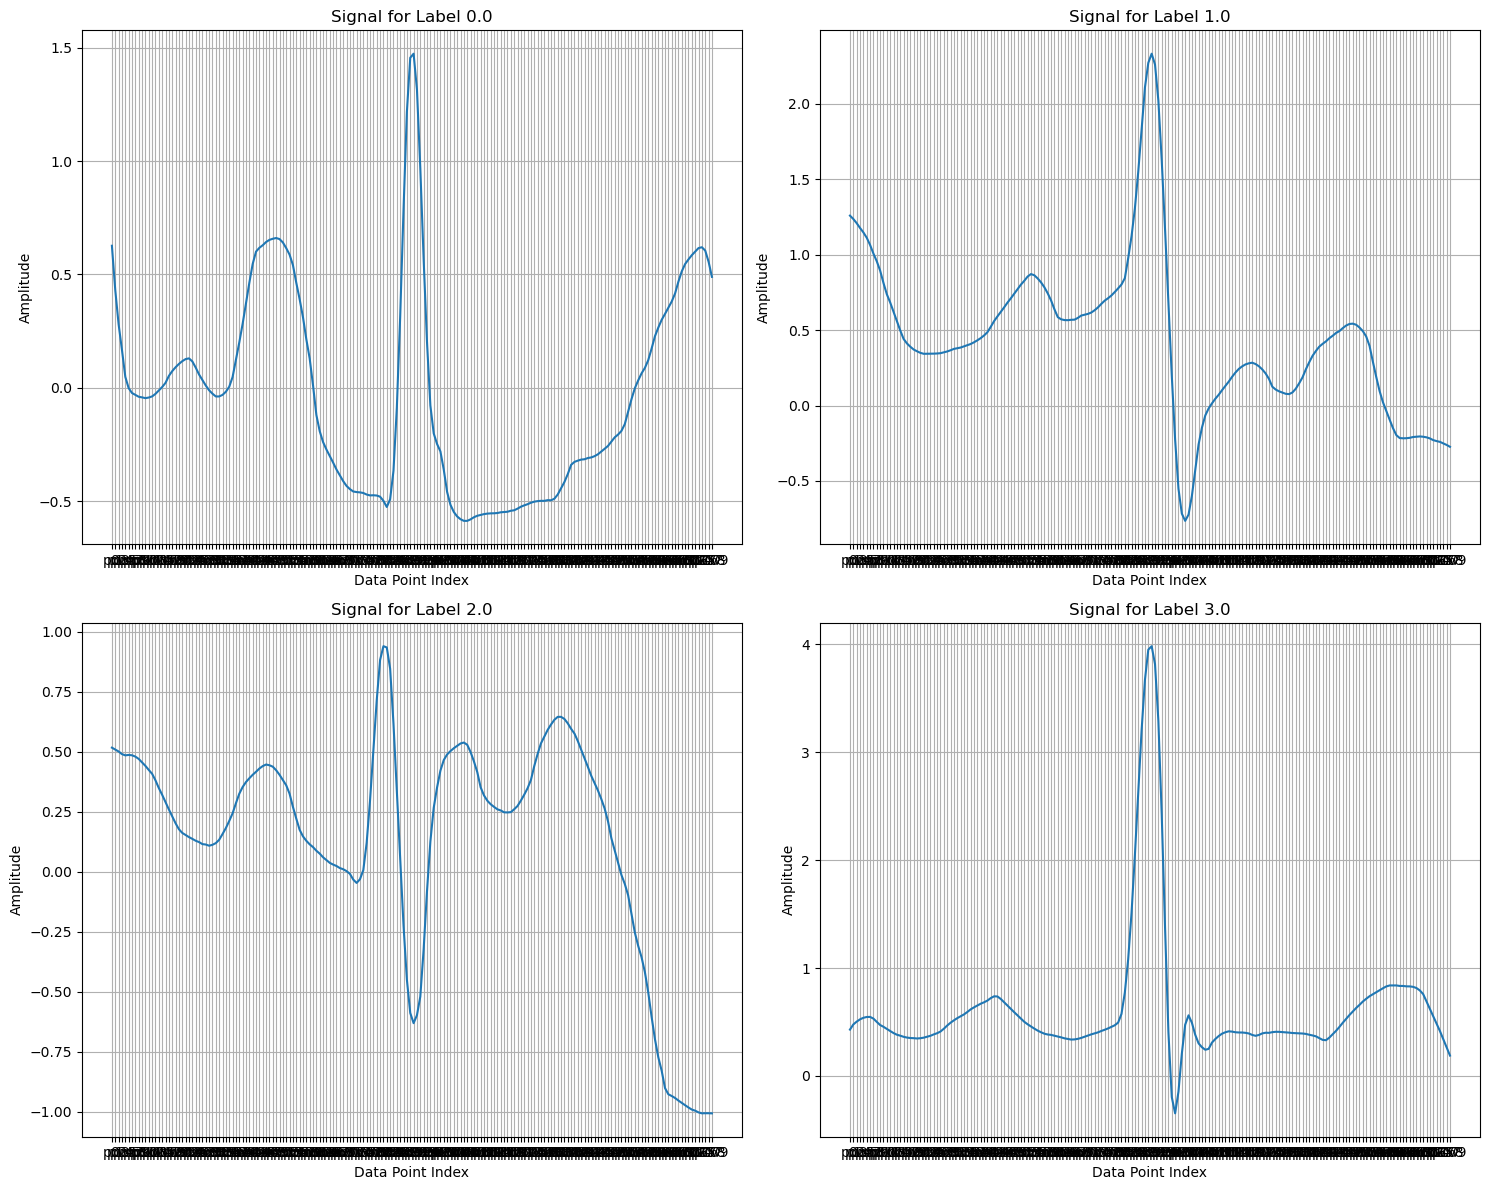

In [9]:
import matplotlib.pyplot as plt

# Plot 4 signals, one for each class, in one big figure
labels_to_plot = processed_df['y'].unique()

plt.figure(figsize=(15, 12))

for i, label in enumerate(labels_to_plot, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots
    label_data = processed_df[processed_df['y'] == label].drop(['y','id'], axis=1).iloc[0]
    plt.plot(label_data)
    plt.title(f'Signal for Label {label}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.tight_layout()
plt.show()


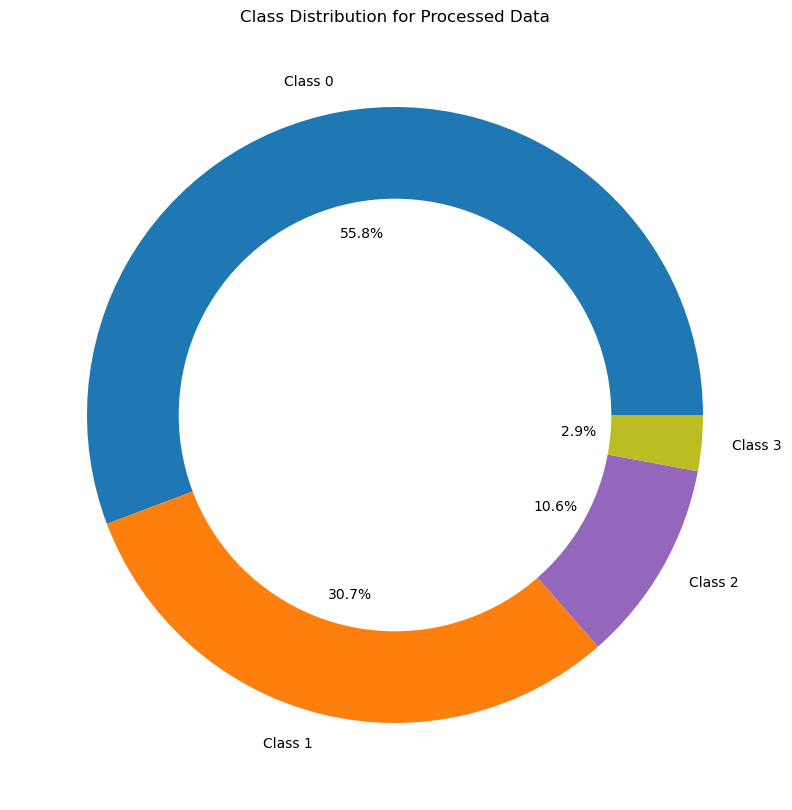

In [10]:

# representation of classes % wise
per_class_processed = processed_df['y'].value_counts()
plt.figure(figsize=(20, 10))
my_circle_processed = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class_processed, labels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive'], autopct='%1.1f%%')
p_processed = plt.gcf()
p_processed.gca().add_artist(my_circle_processed)
plt.title('Class Distribution for Processed Data')
plt.show()



In [15]:
processed_df.to_csv('df_heartbeats.csv')

## Split for X_test

In [16]:
df_test = pd.read_csv('X_test.csv')

In [17]:
from sklearn.preprocessing import StandardScaler


scaled_test_df = df_test.drop(columns=['id'], axis=1).copy()


df_test = df_test.fillna(0)
scaled_test_df = df_test.drop(columns=['id'], axis=1).copy()


features = scaled_test_df
scaled_features = scaler.transform(features)

scaled_test_df = pd.DataFrame(data=scaled_features, columns=scaled_test_df.columns)
scaled_test_df['id'] = df_test['id']
df_test = scaled_test_df.copy()

In [18]:
df_test.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17798,x17799,x17800,x17801,x17802,x17803,x17804,x17805,x17806,id
0,0.199953,0.201090,0.201428,0.198220,0.192596,0.186994,0.181694,0.174092,0.166294,0.155286,...,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,0
1,-0.274201,-0.268954,-0.265333,-0.264619,-0.265891,-0.264183,-0.266071,-0.267776,-0.268328,-0.273809,...,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,1
2,-1.565104,-1.814571,-2.101815,-2.325086,-2.499619,-2.671394,-2.820303,-3.009621,-3.184872,-3.277478,...,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,2
3,-0.120718,-0.114116,-0.109746,-0.105692,-0.100948,-0.098845,-0.097103,-0.094994,-0.096767,-0.096952,...,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,3
4,-0.186496,-0.194300,-0.204209,-0.214431,-0.221161,-0.227753,-0.232277,-0.236618,-0.242594,-0.259313,...,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,-0.013981,4


In [19]:
# Import the necessary libraries
#import wfdb
import numpy as np
import pandas as pd
import biosppy.signals.ecg as ecg

# Define the window size for extracting heartbeats
window_size = 180

# Initialize an empty list to store the processed data
processed_data = []

# Loop through each row of the original dataframe
for index, row in df_test.iterrows():
    signal = row.drop(columns=['id'], axis=1).dropna().to_numpy(dtype='float32') 
    id = row['id'] 

    # Detect the QRS complexes using the gqrs algorithm
    rpeaks = ecg.hamilton_segmenter(signal, sampling_rate=300)['rpeaks']

    # Extract the heartbeats from the signal using the QRS locations and the window size
    heartbeats = []
    for rpeak in rpeaks:
        start = max(0, rpeak - window_size // 2)
        end = min(len(signal), rpeak + window_size // 2)
        heartbeat = signal[start:end]
        if len(heartbeat) == window_size:
            heartbeats.append(heartbeat)

    if len(heartbeats) == 0:
        print(f"No heartbeats extracted for signal with id {id}")

    # Loop through each heartbeat
    for heartbeat in heartbeats:
        # Flatten the heartbeat array to a list
        heartbeat = heartbeat.flatten().tolist()

        # Append the label and the id to the heartbeat list
        heartbeat.append(id)

        # Append the heartbeat list to the processed data list
        processed_data.append(heartbeat)

# Convert the processed data list to a pandas dataframe
processed_df_test = pd.DataFrame(processed_data)

# Rename the columns of the processed dataframe
columns = [f"p{i}" for i in range(window_size)] # Assuming the window size is the number of data points per heartbeat
columns.append("id") # The id column
processed_df_test.columns = columns

processed_df_test = pd.DataFrame(processed_df_test)


In [20]:
processed_df_test.to_csv('X_test_heartbeats.csv')

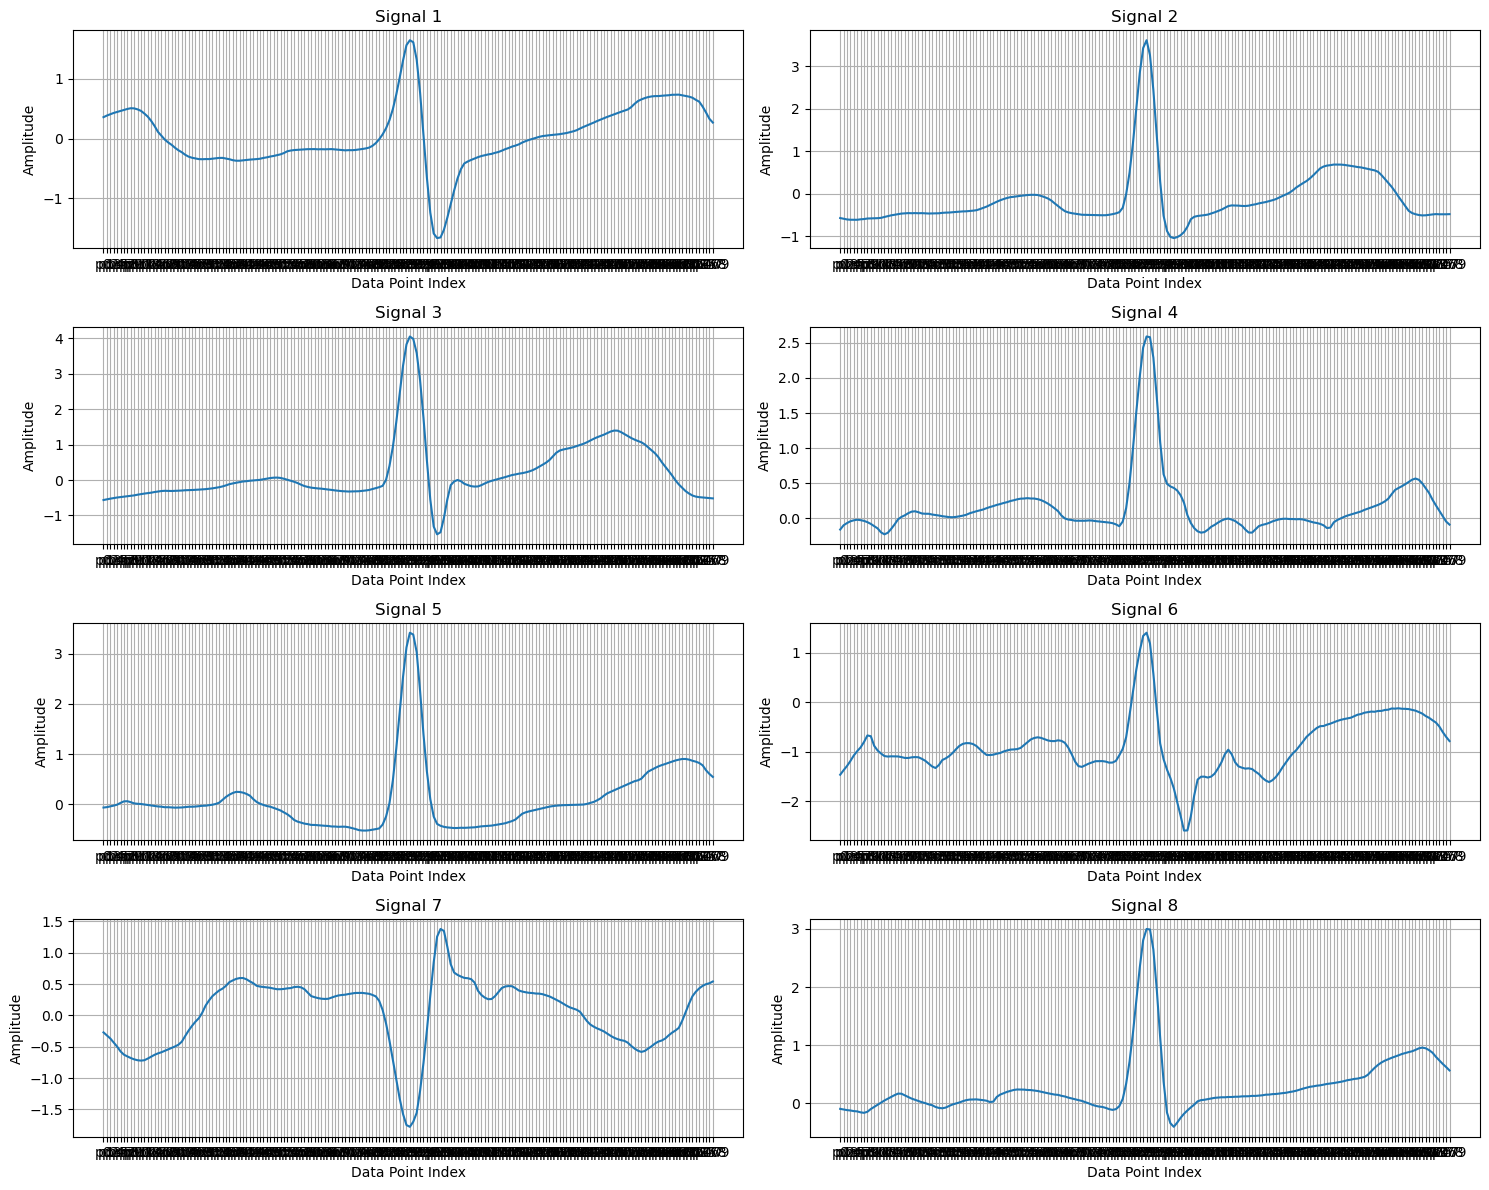

In [17]:
import random

# Plot 8 random signals from processed_df_test
plt.figure(figsize=(15, 12))

# Get a random sample of 8 signals
random_signals = processed_df_test.drop('id', axis=1).sample(n=8, random_state=69)

for i, (_, signal) in enumerate(random_signals.iterrows(), 1):
    plt.subplot(4, 2, i)  # Create a 4x2 grid of subplots
    plt.plot(signal)
    plt.title(f'Signal {i}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.tight_layout()
plt.show()
